#添加库函数

In [31]:
import os
import torch
import torch.nn as nn
import math
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
import numpy as np
from tqdm.notebook import tqdm
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
)
from pytorch3d.vis.plotly_vis import plot_batch_individually
from pytorch3d.ops.points_normals import estimate_pointcloud_normals
from pytorch3d.ops.mesh_face_areas_normals import mesh_face_areas_normals
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

In [32]:
# 加载卫星模型
trg_obj = 'wx_origin.obj'

In [33]:
# 读取卫星各项参数
# We read the target 3D model using load_obj
verts, faces, aux = load_obj(trg_obj)

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 
# (scale, center) will be used to bring the predicted mesh to its original center and scale
# Note that normalizing the target mesh, speeds up the optimization but is not necessary!
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale *100

# We construct a Meshes structure for the target mesh
trg_mesh = Meshes(verts=[verts], faces=[faces_idx])

# 为mesh添加材质信息
verts_rgb = torch.ones_like(trg_mesh.verts_packed())*255  # 使用纯白色作为默认颜色
verts_rgb = verts_rgb.unsqueeze(0)
textures = TexturesVertex(verts_features=verts_rgb)
trg_mesh.textures = textures

/home/hkz/.conda/envs/3d_env/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:546: UserWarning:

No mtl file provided



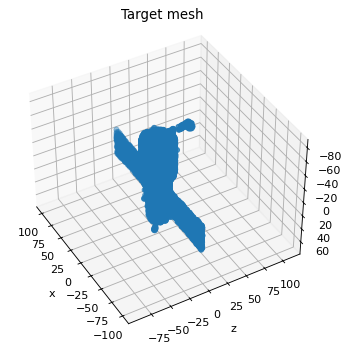

In [34]:
def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(220, 30)
    ax.axis('equal')
    plt.show()

plot_pointcloud(trg_mesh, "Target mesh")
plot_batch_individually(trg_mesh)

In [35]:
# 计算法向量
points = sample_points_from_meshes(trg_mesh, 500)
normal = estimate_pointcloud_normals(points)

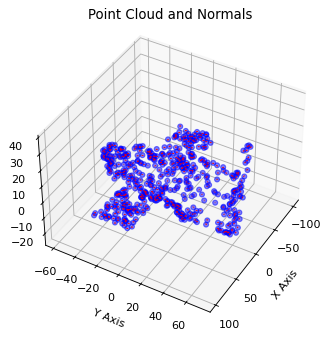

In [36]:
def points_normal_visual(points,normals):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)
    x_normal, y_normal, z_normal = normals.clone().detach().cpu().squeeze().unbind(1)
    # 绘制点云
    ax.scatter(x, y, z, color='b', marker='o', alpha=0.5)

    # 绘制法向量
    # 此处通过 quiver 函数, scale=10 调整法向量的长度
    ax.quiver(
        x, y, z,
        x_normal, y_normal, z_normal,
        length=0.5, color='r', normalize=True
    )

    # 设置坐标轴标签
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')

    # 设置标题
    ax.set_title('Point Cloud and Normals')
    ax.view_init(40, 30)
    # 显示图形
    plt.show()

points_normal_visual(points,normal)

In [37]:
areas, normals = mesh_face_areas_normals(trg_mesh.verts_packed(), trg_mesh.faces_packed())

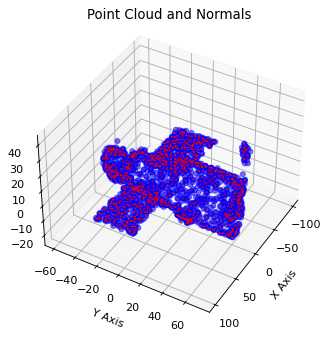

In [38]:
sampled_points, point_normals= sample_points_from_meshes(trg_mesh, 2000,return_normals = True)
# point_normals = normals[sampled_face_idxs]
points_normal_visual(sampled_points,point_normals)

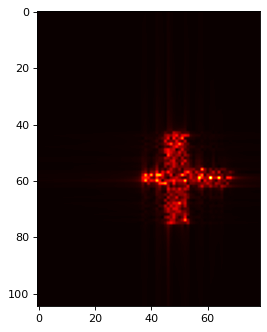

In [39]:
class ISAR_render(nn.Module):
    def __init__(self, device) -> None:
        super().__init__()
        self.c = torch.tensor([299792458.0], device=device)
        self.Tcoh = torch.tensor([22.1504*4*6], device=device)
        self.PRF = torch.tensor([20.0], device=device)
        self.fc = torch.tensor([9.7e9], device=device)
        self.Tp = torch.tensor([5e-4], device=device)
        self.B = torch.tensor([4e7], device=device)
        self.Range_map,self.Dopple_map = torch.meshgrid(torch.linspace(-3.75*51,3.75*27,79).to(device),torch.linspace(-0.1*59,0.1*45,105).to(device), indexing='xy')
        self.lambda1 = self.c/self.fc
        self.RangeRes = self.c/self.B/2
        self.complex_i = torch.tensor([1j], dtype=torch.complex64, device=device)

    def forward(self, mesh, RadarLos, SpinAxis, Omega):
        # 输入
        # mesh为pytorch3d自带的结构，采样后采样点为：sampled_points [batchsize,N,3] point_normals [batchsize,N,3]
        # 雷达视线方向 RadarLos [batchsize,3]
        # 转轴 SpinAxis [batchsize,3]
        sampled_points, point_normals= sample_points_from_meshes(mesh, 10000,return_normals = True)
        DopplerAxis = torch.cross(RadarLos,SpinAxis,dim = -1)
        point_vel = torch.cross(SpinAxis.unsqueeze(1),sampled_points,dim = -1)
        point_vel_Radial = Omega * torch.sum(RadarLos.unsqueeze(1)*point_vel,dim=2)
        point_doppler = -2*point_vel_Radial/self.lambda1
        point_range = torch.sum(RadarLos.unsqueeze(1)*sampled_points,dim=2)
        point_Amp = torch.sum(RadarLos.unsqueeze(1)*point_normals, dim=2)
        DopplerRes = self.lambda1/2/Omega/self.Tcoh
        point_Amp = torch.clamp(point_Amp,max=0)
        image_AllPoint = point_Amp.unsqueeze(2).unsqueeze(3)*torch.sinc(1/self.RangeRes*(self.Range_map.unsqueeze(0).unsqueeze(1)-point_range.unsqueeze(2).unsqueeze(3))) * torch.sinc(1/DopplerRes*(self.Dopple_map.unsqueeze(0).unsqueeze(1)-point_doppler.unsqueeze(2).unsqueeze(3))) * torch.exp(-4*math.pi*self.complex_i/self.lambda1*point_range.unsqueeze(2).unsqueeze(3))
        # image_AllPoint = torch.abs(point_Amp.unsqueeze(2).unsqueeze(3)*torch.sinc(1/self.RangeRes*(self.Range_map.unsqueeze(0).unsqueeze(1)-point_range.unsqueeze(2).unsqueeze(3))) * torch.sinc(1/DopplerRes*(self.Dopple_map.unsqueeze(0).unsqueeze(1)-point_vel_Radial.unsqueeze(2).unsqueeze(3))) * torch.exp(-4*math.pi*self.complex_i/self.lambda1*point_range.unsqueeze(2).unsqueeze(3)))
        image = torch.sum(image_AllPoint,dim=1)

        return image
    
ISAR_render1 = ISAR_render(device)

RadarLos = torch.tensor([-1/2,0,-math.sqrt(3)/2], device=device)
RadarLos = torch.tensor([0,math.sqrt(3)/2,-1/2], device=device)
RadarLos = torch.tensor([0,math.sqrt(3)/2,-1/2], device=device)
SpinAxis = torch.tensor([0,0,1.0], device=device)
Omega = torch.tensor([2*math.pi/3600/6], device=device)
RadarLos = RadarLos.unsqueeze(0)
SpinAxis = SpinAxis.unsqueeze(0)
Omega = Omega.unsqueeze(0)

image = ISAR_render1(trg_mesh,RadarLos,SpinAxis,Omega)

image_clone = image.clone().squeeze(0).detach().cpu()
image_abs = torch.abs(image_clone).numpy()

plt.imshow(image_abs,cmap='hot')

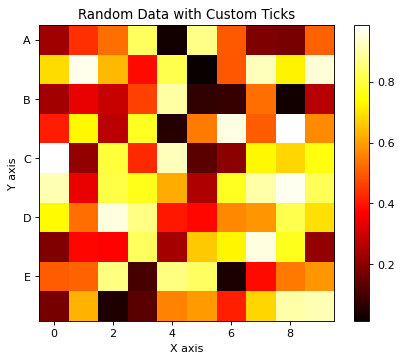

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# 创建一些示例数据
data = np.random.rand(10, 10)

# 使用 imshow 显示数据
img = plt.imshow(data, cmap='hot', interpolation='nearest')

# 添加颜色条
plt.colorbar(img)

# 设置自定义 x 和 y 刻度
plt.xticks(ticks=np.arange(0, 10, step=2), labels=['0', '2', '4', '6', '8'])  # 自定义 x 方向的刻度和标签
plt.yticks(ticks=np.arange(0, 10, step=2), labels=['A', 'B',  'C', 'D', 'E']) # 自定义 y 方向的刻度和标签

# 添加标题和标签
plt.title('Random Data with Custom Ticks')
plt.xlabel('X axis')
plt.ylabel('Y axis')

# 显示图像
plt.show()